### Named Entity Recognition
### Run if not alread installed

In [ ]:
!pip install keras
!pip install tensorflow==2.3.0
!pip install pydot
!pip install graphviz
!pip install pydotplus

In [7]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('stopwords')
from bs4 import BeautifulSoup
import collections
from collections import Counter
import re
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

from random import randrange

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sreep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sreep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sreep\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
data = pd.read_csv('data.csv')

In [4]:
from itertools import chain
def createIndexDictionary(dataset, type):
    tok2idxArr = {}
    idx2tokArr = {}
    
    if type == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tokArr = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idxArr = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idxArr, idx2tokArr


token2idx, idx2token = createIndexDictionary(data, 'token')
tag2idx, idx2tag = createIndexDictionary(data, 'tag')

In [5]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
words = list(set(data["Word"].values))
tags = list(set(data["Tag"].values))

In [6]:
data.isna().any() #Detect Missing Values

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [14]:
#Dataset cannot have any missing values and hence fill it with fillna method
data_fillna = data.fillna(method='ffill', axis=0)
grouped_data = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

<ipython-input-14-1ee94d57c067>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_data = data_fillna.groupby(['Sentence #'],as_index=False


In [15]:
def split_padded_dataset(grouped_data, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = grouped_data['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = grouped_data['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

#Spliting data into train and test datat set.
train_tokens, test_tokens, train_tags, test_tags = split_padded_dataset(grouped_data, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [16]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in grouped_data['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35173 
output_dim:  64 
input_length:  104 
n_tags:  17


In [17]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
def createLSTMModel():
    input_word = Input(shape=(input_length,))
    model = Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length)(input_word)
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(n_tags,activation='softmax'))(model)
    model = Model(input_word,out)
    model.summary()
    
    return model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 104)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 104, 64)           2251072   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 104, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          132000    
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           3417      
Total params: 2,386,489
Trainable params: 2,386,489
Non-trainable params: 0
_________________________________________________________________


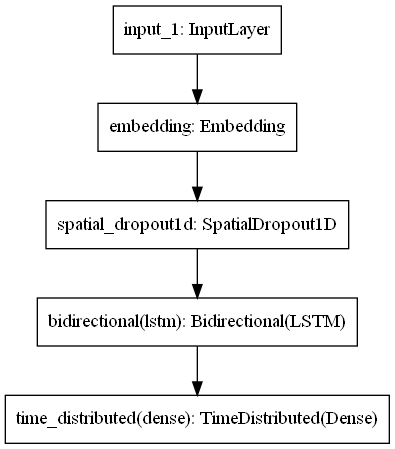

In [18]:
def train_model(X, y, model):   
    hist = model.fit(X, y, batch_size=32, verbose=1, epochs=3, validation_split=0.2)
       
nerModel = createLSTMModel()
plot_model(nerModel)

In [20]:
nerModel.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
train_model(train_tokens, np.array(train_tags), nerModel)

Epoch 1/3
1080/1080 [==============================] - 175s 162ms/step - loss: 0.1074 - accuracy: 0.9783 - val_loss: 0.0349 - val_accuracy: 0.9901
Epoch 2/3
1080/1080 [==============================] - 170s 158ms/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 0.0256 - val_accuracy: 0.9923
Epoch 3/3
1080/1080 [==============================] - 169s 156ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0236 - val_accuracy: 0.9929


In [23]:
nerModel.evaluate(test_tokens, np.array(test_tags))

150/150 [==============================] - 3s 22ms/step - loss: 0.0235 - accuracy: 0.9930


[0.023497821763157845, 0.9930471181869507]

In [35]:
#Testing a randomly selected sentence from the test_data
i = randrange(len(test_tokens))
p = nerModel.predict(np.array([test_tokens[i]]))
p = np.argmax(p[0], axis=-1)
true = np.argmax(test_tags[i], -1)
print("{:25}||{:10}||{}".format("Word", "Actual", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_tokens[i], true, p):
    if w != 0:
        print("{:25}: {:10} {}".format(words[w-1], tags[t], tags[pred]))

Word                     ||Actual    ||Pred
4.1                      : O          O
install                  : O          O
focuses                  : O          O
turbans                  : O          O
HAVING                   : O          O
Charlotte                : O          O
kidnappings              : O          O
Claus                    : O          O
midwest                  : B-geo      B-geo
jolted                   : B-tim      B-tim
Samuel                   : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O          O
targeting                : O

In [25]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [36]:
def cleanText(test_sentence): 
    cleantext = BeautifulSoup(test_sentence).get_text()
    cleantext = re.sub("\d+", " ", cleantext) #remove digits
    cleantext = re.sub('[^A-Za-z0-9]+', ' ', cleantext) #remove special characters
    cleantext = re.sub("\s+", " ", cleantext) #remove extra spaces

    cleantext = word_tokenize(cleantext)
    cleantext = [word for word in cleantext if word not in stopwords.words('english')]
    return cleantext;

test_sentence="Google LLC is an Indian American multinational technology company offers multitude of data for Australian people that specializes in Internet-related services and products, which include online advertising technologies, a search engine, cloud computing, software, and hardware."
cleaned_test_sentence = cleanText(test_sentence);

x_test_sent = pad_sequences(sequences=[[token2idx.get(w, 0) for w in cleaned_test_sentence]],padding="post", value=0, maxlen=input_length)

In [37]:
p = nerModel.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
pos = np.argmax(test_tags[i], -1)
print("{:25}||{:10}||{}".format("Word","POS", "Prediction"))
for w,t, pred in zip(cleaned_test_sentence, pos,p[0]):
    print("{:25}: {:10} {}".format(w, tags[t], tags[pred]))

Word                     ||POS       ||Prediction
Google                   : O          B-org
LLC                      : O          O
Indian                   : O          B-gpe
American                 : O          B-gpe
multinational            : O          O
technology               : O          O
company                  : O          O
offers                   : O          O
multitude                : B-geo      O
data                     : B-tim      O
Australian               : O          B-gpe
people                   : O          O
specializes              : O          O
Internet                 : O          O
related                  : O          O
services                 : O          O
products                 : O          O
include                  : O          O
online                   : O          O
advertising              : O          O
technologies             : O          O
search                   : O          O
engine                   : O          O
cloud         